In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
import joblib
import os
import sys
import shutil
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
from collections import defaultdict

In [2]:
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from utilities import bs_calibrate, bs_results, utils

# DATA PREPRATION

In [4]:
df = pd.read_csv("../dibh_clinical_only/original_training_data.csv")
data_day1 = df[df['day'] == 1]
X = data_day1.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y = data_day1['DIBH_Y0N1']
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.30, random_state=42)

df_internal_val = pd.read_csv("../dibh_clinical_only/final_internal_validation13052024.csv")
data_day1_val = df_internal_val[df_internal_val['day'] == 1]
X_int_val = data_day1_val.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y_int_val = data_day1_val['DIBH_Y0N1']

categorical_features = ['al_N0_Y1', 'surgery_BCS1MRM2', 'chemo_No0_Adj1_NAdj2', 'comorb_no0_cardio1_others2']
continuous_features = ['age', 'BMI', 'ul_amp', 'll_amp', 'average_amp', 'ahd']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, continuous_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# HYPERPARAMETER OPTIMIZATION

In [3]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }
    rf_clf = make_pipeline(preprocessor, RandomForestClassifier(**params, random_state=42))
    cv_roc_auc = cross_val_score(rf_clf, X_t, y_t, cv=10, scoring='roc_auc').mean()
    return cv_roc_auc

In [5]:
storage_name = "sqlite:///db.sqlite3"
# sampler = TPESampler(seed=72)
# # Random seeds - 42,50,58,66,72
# study = optuna.create_study(direction='maximize', sampler=sampler, storage=storage_name, study_name="RF_one_day_assessment_final04")
# study.optimize(objective, n_trials=1000)


In [7]:
loaded_study = optuna.create_study(study_name="RF_one_day_assessment_final04", storage=storage_name, load_if_exists=True)
best_params = loaded_study.best_params

[I 2024-08-03 15:03:31,639] Using an existing study with name 'RF_one_day_assessment_final04' instead of creating a new one.


## Bootstrap and Calibration

In [8]:
# For Gradient Boosting
top_models_rf, results_rf, calibration_data_rf = bs_calibrate.bootstrap_model_evaluation(
    X_t, y_t, X_v, y_v, preprocessor, RandomForestClassifier, best_params
)

Bootstrap sample no. 25 ------ Finished
Bootstrap sample no. 50 ------ Finished
Bootstrap sample no. 75 ------ Finished
Bootstrap sample no. 100 ------ Finished
Bootstrap sample no. 125 ------ Finished
Bootstrap sample no. 150 ------ Finished
Bootstrap sample no. 175 ------ Finished
Bootstrap sample no. 200 ------ Finished
Bootstrap sample no. 225 ------ Finished
Bootstrap sample no. 250 ------ Finished
Bootstrap sample no. 275 ------ Finished
Bootstrap sample no. 300 ------ Finished
Bootstrap sample no. 325 ------ Finished
Bootstrap sample no. 350 ------ Finished
Bootstrap sample no. 375 ------ Finished
Bootstrap sample no. 400 ------ Finished
Bootstrap sample no. 425 ------ Finished
Bootstrap sample no. 450 ------ Finished
Bootstrap sample no. 475 ------ Finished
Bootstrap sample no. 500 ------ Finished
Bootstrap sample no. 525 ------ Finished
Bootstrap sample no. 550 ------ Finished
Bootstrap sample no. 575 ------ Finished
Bootstrap sample no. 600 ------ Finished
Bootstrap sample no

## Saving Data

In [9]:
joblib.dump(top_models_rf, '../RF_Models/top_models_rf.joblib')
joblib.dump(results_rf, '../RF_Models/results.joblib')
joblib.dump(calibration_data_rf, '../RF_Models/calibration_data_rf.joblib')

['../RF_Models/calibration_data_rf.joblib']

## Plotting and calibration curve

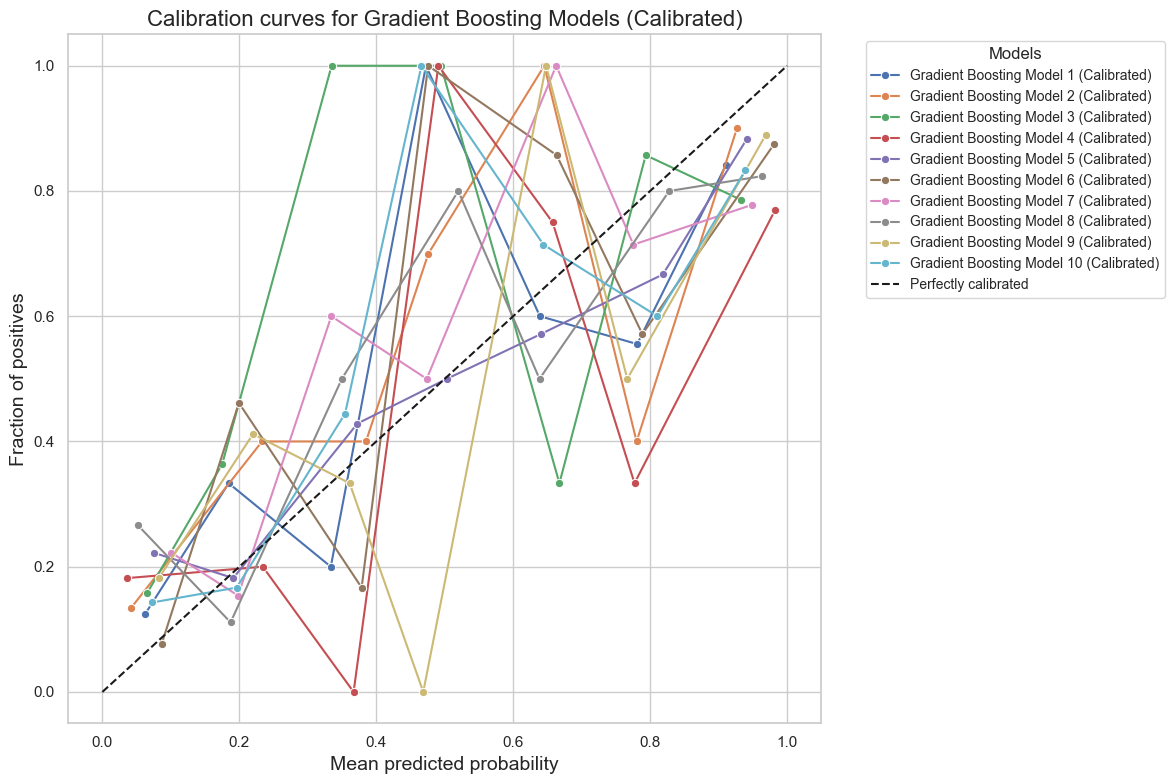

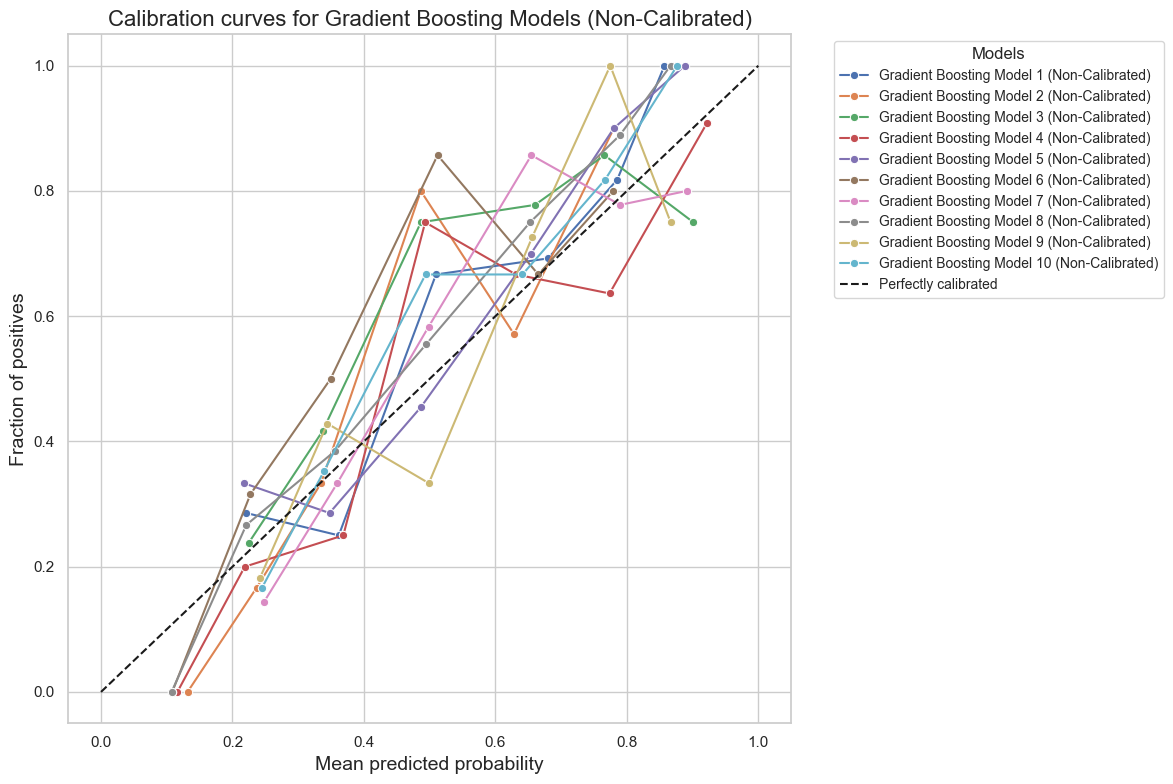

In [10]:
# Assuming calibration_data_gb and calibration_data_cat have the top 10 predicted probabilities
# for Gradient Boosting models
loaded_calibration_data = joblib.load('../RF_Models/calibration_data_rf.joblib')
# Example: Plotting calibration curves for top 10 Gradient Boosting models
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_calibrated'], n_bins=7, model_label="Gradient Boosting", calibrated=True)
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_non_calibrated'], n_bins=7, model_label="Gradient Boosting", calibrated=False)



## Extract feature importances and save them in a csv file

In [11]:
# Save to CSV
df_importances = utils.save_feature_importances_to_csv(filename='feature_importances.csv', 
                                                       model_name_prefix='gb', 
                                                       top_models_path='../RF_Models/top_models_rf.joblib')

Data saved to - feature_importances.csv


## Plot Feature Importance

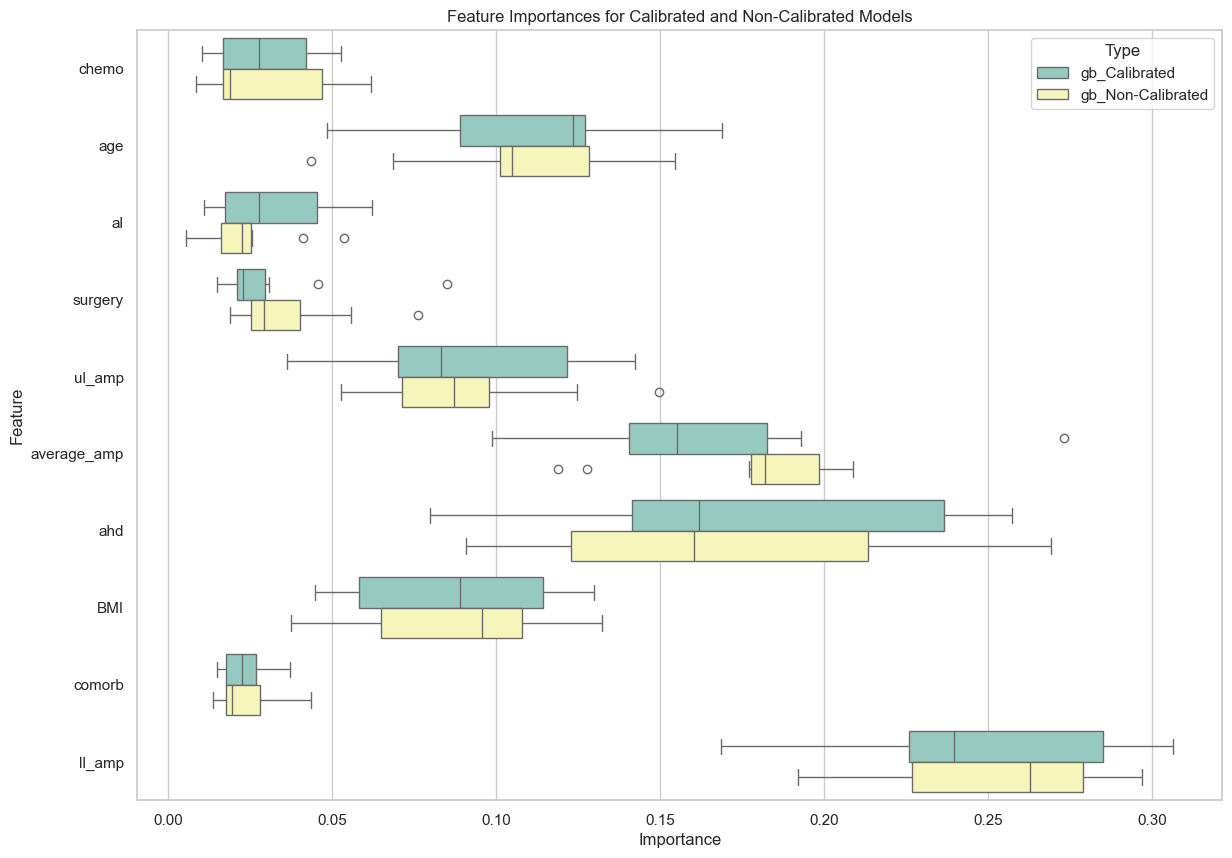

In [12]:
# Box plot
plt.figure(figsize=(14, 10))
sns.boxplot(x='Importance', y='Feature', hue='Type', data=df_importances, palette='Set3')
plt.title('Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

## Store the results for models into a csv file

In [13]:
loaded_results = joblib.load('../RF_Models/results.joblib')
calibrated_summary, non_calibrated_summary = bs_results.get_results(loaded_results)

Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.743033   0.811323  0.680219  0.732147  0.770156
std           0.018037   0.060597  0.094827  0.037692  0.014902
min           0.688525   0.681818  0.468750  0.625000  0.700970
max           0.803279   0.950000  0.937500  0.828571  0.820582
95% CI lower  0.707680   0.692552  0.494358  0.658272  0.740948
95% CI upper  0.778386   0.930094  0.866079  0.806023  0.799365

Non-Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.741279   0.815998  0.670063  0.727743  0.768898
std           0.018862   0.061968  0.096320  0.038633  0.015256
min           0.688525   0.674419  0.468750  0.612245  0.696121
max           0.803279   0.950000  0.906250  0.823529  0.817888
95% CI lower  0.704310   0.694541  0.481276  0.652023  0.738995
95% CI upper  0.778248   0.937454  0.858849  0.803464  0.798800


In [14]:
filename='../saved_models/final_results.csv'
model_name = 'RF'
bs_results.save_results_to_csv(calibrated_summary, non_calibrated_summary, filename=filename, model_name=model_name)

'Data saved to ../saved_models/final_results.csv'

# BOOTSTRAP SAMPLING and TRAINING

In [39]:

top_models = []
fraction_of_positives_calibrated_list = []
mean_predicted_value_calibrated_list = []
fraction_of_positives_non_calibrated_list = []
mean_predicted_value_non_calibrated_list = []
results = []

for i in range(1000):
    X_resampled, y_resampled = resample(X_t, y_t)
    X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2)

    rf_pipeline = make_pipeline(preprocessor, RandomForestClassifier(**best_params, random_state=42))
    rf_pipeline.fit(X_train_resampled, y_train_resampled)
    y_proba_non_calibrated = rf_pipeline.predict_proba(X_v)[:, 1]

    best_rf_pipeline = make_pipeline(preprocessor, RandomForestClassifier(**best_params, random_state=42))
    model = CalibratedClassifierCV(best_rf_pipeline, method='isotonic', cv=10)
    model.fit(X_train_resampled, y_train_resampled)
    y_proba_calibrated = model.predict_proba(X_v)[:, 1]

    fraction_of_positives_non_calibrated, mean_predicted_value_non_calibrated = calibration_curve(y_v, y_proba_non_calibrated, n_bins=6)
    if len(fraction_of_positives_non_calibrated) == 6:
        fraction_of_positives_non_calibrated_list.append(fraction_of_positives_non_calibrated)
        mean_predicted_value_non_calibrated_list.append(mean_predicted_value_non_calibrated)

    fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_v, y_proba_calibrated, n_bins=6)
    if len(fraction_of_positives_calibrated) == 6:
        fraction_of_positives_calibrated_list.append(fraction_of_positives_calibrated)
        mean_predicted_value_calibrated_list.append(mean_predicted_value_calibrated)

    fpr, tpr, thresholds = roc_curve(y_v, y_proba_calibrated)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_optimal = (y_proba_calibrated >= optimal_threshold).astype(int)

    model_info = {
        'model': model,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'roc_auc': roc_auc,
        'optimal_threshold': optimal_threshold,
        'accuracy': accuracy_score(y_v, y_pred_optimal),
        'precision': precision_score(y_v, y_pred_optimal),
        'recall': recall_score(y_v, y_pred_optimal),
        'f1_score': f1_score(y_v, y_pred_optimal),
        'confusion_matrix': confusion_matrix(y_v, y_pred_optimal),
        'classification_report': classification_report(y_v, y_pred_optimal)
    }

    model_info_without_model = {key: value for key, value in model_info.items() if key != 'model'}
    results.append(model_info_without_model)

    if len(top_models) < 10:
        top_models.append(model_info)
    else:
        min_index = min(range(len(top_models)), key=lambda x: (top_models[x]['roc_auc'], top_models[x]['recall']))
        if roc_auc > top_models[min_index]['roc_auc']:
            top_models[min_index] = model_info

    if (i + 1) % 25 == 0:
        print(f"Bootstrap sample no. {i + 1} ------ Finished")

Bootstrap sample no. 25 ------ Finished
Bootstrap sample no. 50 ------ Finished
Bootstrap sample no. 75 ------ Finished
Bootstrap sample no. 100 ------ Finished
Bootstrap sample no. 125 ------ Finished
Bootstrap sample no. 150 ------ Finished
Bootstrap sample no. 175 ------ Finished
Bootstrap sample no. 200 ------ Finished
Bootstrap sample no. 225 ------ Finished
Bootstrap sample no. 250 ------ Finished
Bootstrap sample no. 275 ------ Finished
Bootstrap sample no. 300 ------ Finished
Bootstrap sample no. 325 ------ Finished
Bootstrap sample no. 350 ------ Finished
Bootstrap sample no. 375 ------ Finished
Bootstrap sample no. 400 ------ Finished
Bootstrap sample no. 425 ------ Finished
Bootstrap sample no. 450 ------ Finished
Bootstrap sample no. 475 ------ Finished
Bootstrap sample no. 500 ------ Finished
Bootstrap sample no. 525 ------ Finished
Bootstrap sample no. 550 ------ Finished
Bootstrap sample no. 575 ------ Finished
Bootstrap sample no. 600 ------ Finished
Bootstrap sample no

# Calculate the mean calibration curve

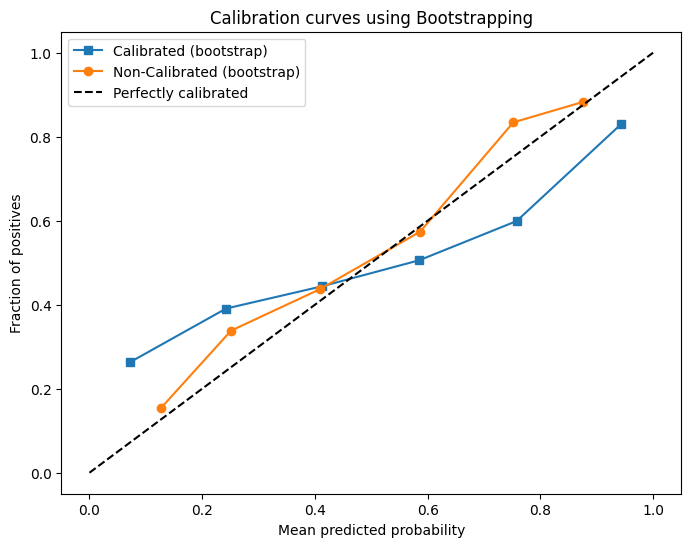

In [32]:
mean_fraction_of_positives_calibrated = np.mean(fraction_of_positives_calibrated_list, axis=0)
mean_mean_predicted_value_calibrated = np.mean(mean_predicted_value_calibrated_list, axis=0)
mean_fraction_of_positives_non_calibrated = np.mean(fraction_of_positives_non_calibrated_list, axis=0)
mean_mean_predicted_value_non_calibrated = np.mean(mean_predicted_value_non_calibrated_list, axis=0)

# Plot the calibration curves
plt.figure(figsize=[8, 6])
plt.plot(mean_mean_predicted_value_calibrated, mean_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
plt.plot(mean_mean_predicted_value_non_calibrated, mean_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves using Bootstrapping")
plt.legend()
plt.show()

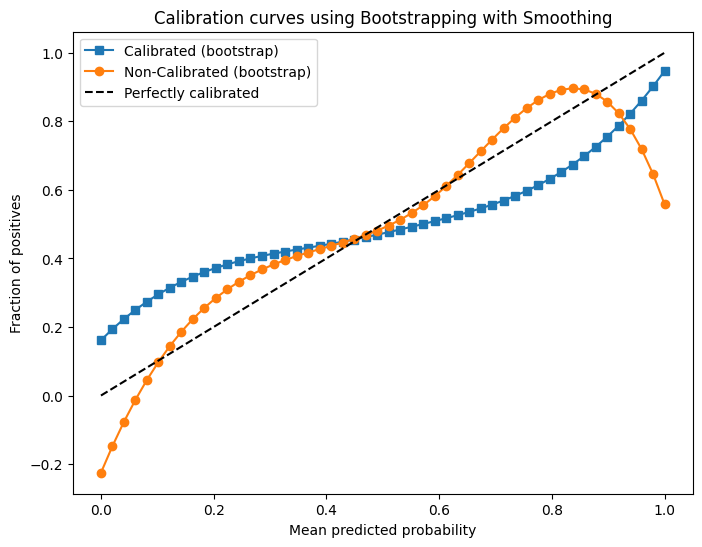

In [33]:
# Generate more points for a smoother curve
xnew = np.linspace(0, 1, 50)

# Smoothing spline for calibrated curve
spl_calibrated = make_interp_spline(mean_mean_predicted_value_calibrated, mean_fraction_of_positives_calibrated, k=3)
smooth_fraction_of_positives_calibrated = spl_calibrated(xnew)

# Smoothing spline for non-calibrated curve
spl_non_calibrated = make_interp_spline(mean_mean_predicted_value_non_calibrated, mean_fraction_of_positives_non_calibrated, k=3)
smooth_fraction_of_positives_non_calibrated = spl_non_calibrated(xnew)

# Plot the smoothed calibration curves
plt.figure(figsize=[8, 6])
plt.plot(xnew, smooth_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
plt.plot(xnew, smooth_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves using Bootstrapping with Smoothing")
plt.legend()
plt.show()

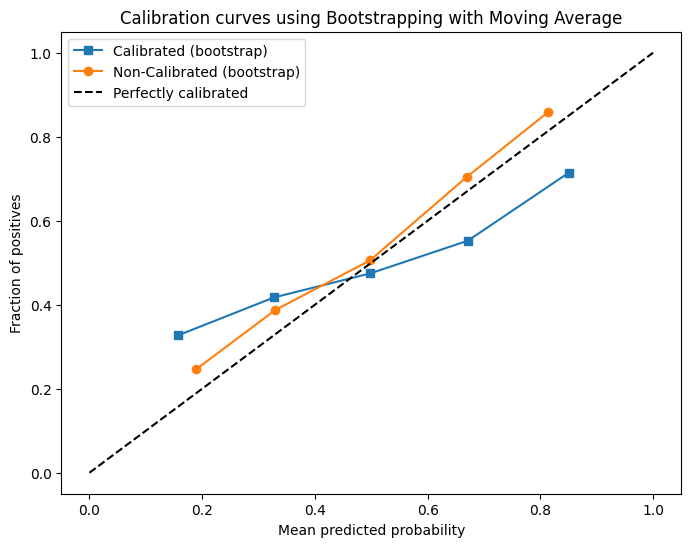

In [34]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average
window_size = 2  # Choose a window size
smooth_fraction_of_positives_calibrated = moving_average(mean_fraction_of_positives_calibrated, window_size)
smooth_mean_predicted_value_calibrated = moving_average(mean_mean_predicted_value_calibrated, window_size)
smooth_fraction_of_positives_non_calibrated = moving_average(mean_fraction_of_positives_non_calibrated, window_size)
smooth_mean_predicted_value_non_calibrated = moving_average(mean_mean_predicted_value_non_calibrated, window_size)

# Plot the smoothed calibration curves
plt.figure(figsize=[8, 6])
plt.plot(smooth_mean_predicted_value_calibrated, smooth_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
plt.plot(smooth_mean_predicted_value_non_calibrated, smooth_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves using Bootstrapping with Moving Average")
plt.legend()
plt.show()

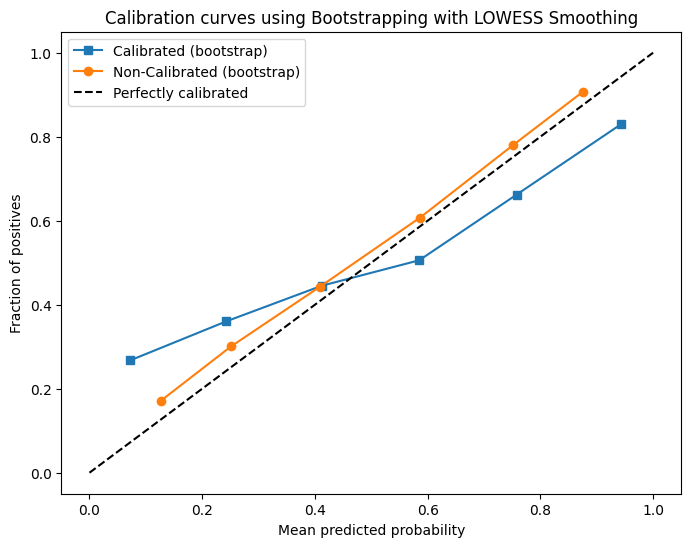

In [35]:
# Apply LOWESS smoothing
smoothed_calibrated = lowess(mean_fraction_of_positives_calibrated, mean_mean_predicted_value_calibrated, frac=0.7)
smoothed_non_calibrated = lowess(mean_fraction_of_positives_non_calibrated, mean_mean_predicted_value_non_calibrated, frac=0.7)

# Extract the smoothed values
smooth_mean_predicted_value_calibrated, smooth_fraction_of_positives_calibrated = smoothed_calibrated[:,0], smoothed_calibrated[:,1]
smooth_mean_predicted_value_non_calibrated, smooth_fraction_of_positives_non_calibrated = smoothed_non_calibrated[:,0], smoothed_non_calibrated[:,1]

# Plot the smoothed calibration curves
plt.figure(figsize=[8, 6])
plt.plot(smooth_mean_predicted_value_calibrated, smooth_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
plt.plot(smooth_mean_predicted_value_non_calibrated, smooth_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves using Bootstrapping with LOWESS Smoothing")
plt.legend()
plt.show()


# RESULTS

In [41]:
df_results = pd.DataFrame(results)

metric_summary = df_results[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].agg(['mean', 'std', 'min', 'max'])
metric_summary.loc['95% CI lower'] = metric_summary.loc['mean'] - 1.96 * metric_summary.loc['std']
metric_summary.loc['95% CI upper'] = metric_summary.loc['mean'] + 1.96 * metric_summary.loc['std']

print(metric_summary)

              accuracy  precision    recall  f1_score   roc_auc
mean          0.743426   0.834393  0.654000  0.724821  0.771040
std           0.016704   0.068017  0.093331  0.035670  0.014572
min           0.688525   0.681818  0.468750  0.612245  0.682651
max           0.803279   0.952381  0.937500  0.828571  0.811422
95% CI lower  0.710687   0.701080  0.471071  0.654909  0.742478
95% CI upper  0.776166   0.967707  0.836929  0.794733  0.799601


# SAVING TOP 10 MODELS

In [42]:
model_folder_path = '../saved_models/one_day_rf_top10'

if os.path.exists(model_folder_path):
    shutil.rmtree(model_folder_path)
os.makedirs(model_folder_path)

for i, m in enumerate(top_models):
    model_path = os.path.join(model_folder_path, f'top_model_{i+1}.joblib')
    joblib.dump(m['model'], model_path)

preprocessor_path = os.path.join(model_folder_path, 'preprocessor.joblib')
joblib.dump(preprocessor, preprocessor_path)

print(f"All top models have been saved to folder: {model_folder_path}")
print(f"Preprocessor has been saved as {preprocessor_path}")


All top models have been saved to folder: ../saved_models/one_day_rf_top10
Preprocessor has been saved as ../saved_models/one_day_rf_top10/preprocessor.joblib


# CREATING ENSEMBLE MODEL

In [43]:

class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        return probabilities
    
    def predict(self, X):
        predictions = np.array([model.predict_proba(X)[:, 1] >= threshold for model, threshold in self.models]).astype(int).T
        final_predictions = mode(predictions, axis=1)[0].flatten()
        return final_predictions

ensemble_models = [(m['model'], m['optimal_threshold']) for m in top_models]
ensemble_classifier = ThresholdedEnsembleClassifier(ensemble_models)

joblib_file = '../saved_models/one_day_rf_top10/ensemble_classifier_rf.joblib'
joblib.dump(ensemble_classifier, joblib_file)

# Load the ensemble classifier from a .joblib file
ensemble_classifier = joblib.load(joblib_file)
y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

print("Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Ensemble F1 Score:", f1_score(y_int_val, y_pred))
print("Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba))


Ensemble Accuracy: 0.6808510638297872
Ensemble Precision: 0.6
Ensemble Recall: 0.631578947368421
Ensemble F1 Score: 0.6153846153846154
Ensemble ROC AUC: 0.7988721804511278


# CALIBRATING THE ENSEMBLE MODEL

In [44]:
class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
        self.calibrator = None
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        if self.calibrator:
            probabilities = self.calibrator.transform(probabilities)
        return probabilities
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        predictions = (probabilities >= 0.5).astype(int)
        return predictions
    
    def calibrate(self, X, y):
        probabilities = self.predict_proba(X)
        self.calibrator = IsotonicRegression(out_of_bounds='clip')
        self.calibrator.fit(probabilities, y)
        return self

ensemble_models = [(m['model'], m['optimal_threshold']) for m in top_models]
ensemble_classifier = ThresholdedEnsembleClassifier(ensemble_models)

# Save the ensemble classifier before calibration
joblib_file = '../saved_models/one_day_rf_top10/ensemble_classifier_rf.joblib'
joblib.dump(ensemble_classifier, joblib_file)

# Calibrate the ensemble classifier on the prospective internal validation data
ensemble_classifier.calibrate(X_int_val, y_int_val)

# Save the calibrated ensemble classifier
joblib_file_calibrated = '../saved_models/one_day_rf_top10/calibrated_ensemble_classifier_rf.joblib'
joblib.dump(ensemble_classifier, joblib_file_calibrated)

['../saved_models/one_day_rf_top10/calibrated_ensemble_classifier_rf.joblib']

In [45]:
# Now you can use the calibrated ensemble classifier to make predictions
y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

# Evaluate the ensemble performance on prospective data as needed
print("Calibrated Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Calibrated Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Calibrated Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Calibrated Ensemble F1 Score:", f1_score(y_int_val, y_pred))
print("Calibrated Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba))


Calibrated Ensemble Accuracy: 0.723404255319149
Calibrated Ensemble Precision: 0.625
Calibrated Ensemble Recall: 0.7894736842105263
Calibrated Ensemble F1 Score: 0.6976744186046512
Calibrated Ensemble ROC AUC: 0.8270676691729323


# Result for publication

In [3]:
class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        return probabilities
    
    def predict(self, X):
        predictions = np.array([model.predict_proba(X)[:, 1] >= threshold for model, threshold in self.models]).astype(int).T
        final_predictions = mode(predictions, axis=1)[0].flatten()
        return final_predictions

In [4]:
joblib_file = '../saved_models/one_day_rf_top10/ensemble_classifier_rf.joblib'
ensemble_classifier = joblib.load(joblib_file)

In [5]:
y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

print("Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Ensemble F1 Score:", f1_score(y_int_val, y_pred))
print("Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba))

Ensemble Accuracy: 0.6808510638297872
Ensemble Precision: 0.6
Ensemble Recall: 0.631578947368421
Ensemble F1 Score: 0.6153846153846154
Ensemble ROC AUC: 0.7988721804511278


In [6]:
results_df = pd.DataFrame({
    'actual_outcome': y_int_val,
    'predicted_probability': y_proba
})

# Save the DataFrame to a CSV file
results_df.to_csv('../saved_models/one_day_rf_top10/rf_predictions', index=False)